In [1]:
import warnings
from itertools import product
from copy import deepcopy
from rich.progress import track
from os.path import join

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LogisticRegression

from mlresearch.utils import set_matplotlib_style, parallel_loop
from mlresearch.utils._check_pipelines import check_random_states
from recgame.recourse import NFeatureRecourse
from recgame.populations import BasePopulation
from recgame.environments import (
    BankLoanApplication2,
    BankLoanApplication3,
    WillingnessEnvironment,
)
from recgame.visualization import (
    simulations_scores_panel,
    simulations_success_rate_panels,
)
from recgame.utils import generate_synthetic_data

# Environment setup

In [2]:
set_matplotlib_style(8, **{"lines.markersize": 1})

SAVE_PATH = "../assets/multi-agent-dynamic-counterfactual-recourse/analysis/"
N_RUNS = 20

# Some variables to define the problem
RNG_SEED = 42
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Functions definition

In [3]:
def _plot_metric(
    metric,
    relevant_results,
    ax,
    values=None,
    alpha_err=0.2,
    alpha_line=1,
    gauss_filter=False,
    c=None,
):
    if values is None:
        metric_values = np.array(
            [
                [res_.metadata_[i][metric] for i in range(len(res_.metadata_))]
                for res_ in relevant_results
            ]
        )
    else:
        metric_values = values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        y_mean = np.nanmean(metric_values, axis=0)
        y_err = np.nanstd(metric_values, axis=0)
    y_min = y_mean - y_err
    y_max = y_mean + y_err

    x = np.arange(metric_values.shape[1])
    ax.fill_between(x, y_min, y_max, alpha=alpha_err, color=c)
    if gauss_filter:
        sr_smooth = gaussian_filter1d(
            np.where(np.isnan(y_mean), y_mean[~np.isnan(y_mean)].mean(), y_mean),
            sigma=5,
        )
        ax.plot(x, y_mean, alpha=alpha_line, c=c)
        ax.plot(x, sr_smooth, c=c, label=metric.replace("_", " ").title())
    else:
        ax.plot(
            x, y_mean, label=metric.replace("_", " ").title(), alpha=alpha_line, c=c
        )
    return ax


def n_runs_simulations_scores_panel(results, adaptation_list, new_agents_list):
    fig, axes = plt.subplots(
        len(adaptation_list),
        len(new_agents_list),
        figsize=(10, 10),
        layout="constrained",
        sharey=True,
        sharex=True,
    )

    unpacked_results = [setting for result in results for setting in result]
    for adapt, nagents in track(list(product(adaptation_list, new_agents_list))):
        i = adaptation_list.index(adapt)
        j = new_agents_list.index(nagents)
        ax1 = axes[i, j]
        ax2 = ax1.twinx()

        relevant_results = [
            res_[-1]
            for res_ in unpacked_results
            if (res_[0]["adaptation"] == adapt) and (res_[0]["new_agents"] == nagents)
        ]

        # threshold
        p1 = _plot_metric("threshold", relevant_results, ax1, c="#3584e4")
        ax1.tick_params(axis="y", labelcolor="#3584e4")

        # success rate
        succ_rate = np.array(
            [
                np.concatenate([[np.nan], res_.success_rate(1, res_.step_ + 1)])
                for res_ in relevant_results
            ]
        )
        p2 = _plot_metric(
            "success_rate",
            relevant_results,
            ax2,
            succ_rate,
            alpha_err=0.1,
            alpha_line=0.2,
            gauss_filter=True,
            c="#d75c5c",
        )
        ax2.tick_params(axis="y", labelcolor="#d75c5c")

        ax1.set_ylim([0, 1])  # threshold - blue
        ax2.set_ylim([0, 1])  # success rate - red

        if j != len(new_agents_list) - 1:
            ax2.set(yticklabels=[])

        if i == 0 and j == len(new_agents_list) - 1:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc=0, fontsize=12)

        ax1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
        ax2.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))

    for i in range(len(adaptation_list)):
        axes[i, 0].set_ylabel(f"{adaptation_list[i]}")

    for j in range(len(new_agents_list)):
        axes[-1, j].set_xlabel(f"{new_agents_list[j]}")

    fig.supxlabel(r"\# New Agents")
    fig.supylabel("Adaptation")

    return fig, axes

# Bank Loan application - Gaussian adaptation

In [4]:
# Meta-simulation variables
N_LOANS_BLA3 = [10]  # number of loans is fixed
ADAPTATION_BLA3 = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_BLA3 = [8, 9, 10, 11, 12]
N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [5]:
all_runs_bla3 = []
for i, random_state in enumerate(check_random_states(RNG_SEED, N_RUNS)):
    df, y, categorical = generate_synthetic_data(
        N_AGENTS, N_CONTINUOUS, N_CAT, random_state
    )

    lr = LogisticRegression(random_state=random_state).fit(df, y)
    population = BasePopulation(df, categorical=categorical)
    recourse = NFeatureRecourse(lr, n_features=2)

    def _meta_simulation(params):
        loans, adapt, agents = params
        environment = BankLoanApplication3(
            deepcopy(population),
            deepcopy(recourse),
            n_loans=loans,
            adaptation=adapt,
            new_agents=agents,
            random_state=random_state,
        )
        try:
            environment.run_simulation(50)
        except ValueError:
            pass

        return {
            "n_loans": loans,
            "adaptation": adapt,
            "new_agents": agents,
        }, environment

    results_bla3 = parallel_loop(
        _meta_simulation,
        list(product(N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)),
        n_jobs=-1,
        progress_bar=True,
        description=f"Run #{i}",
    )
    all_runs_bla3.append(results_bla3)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

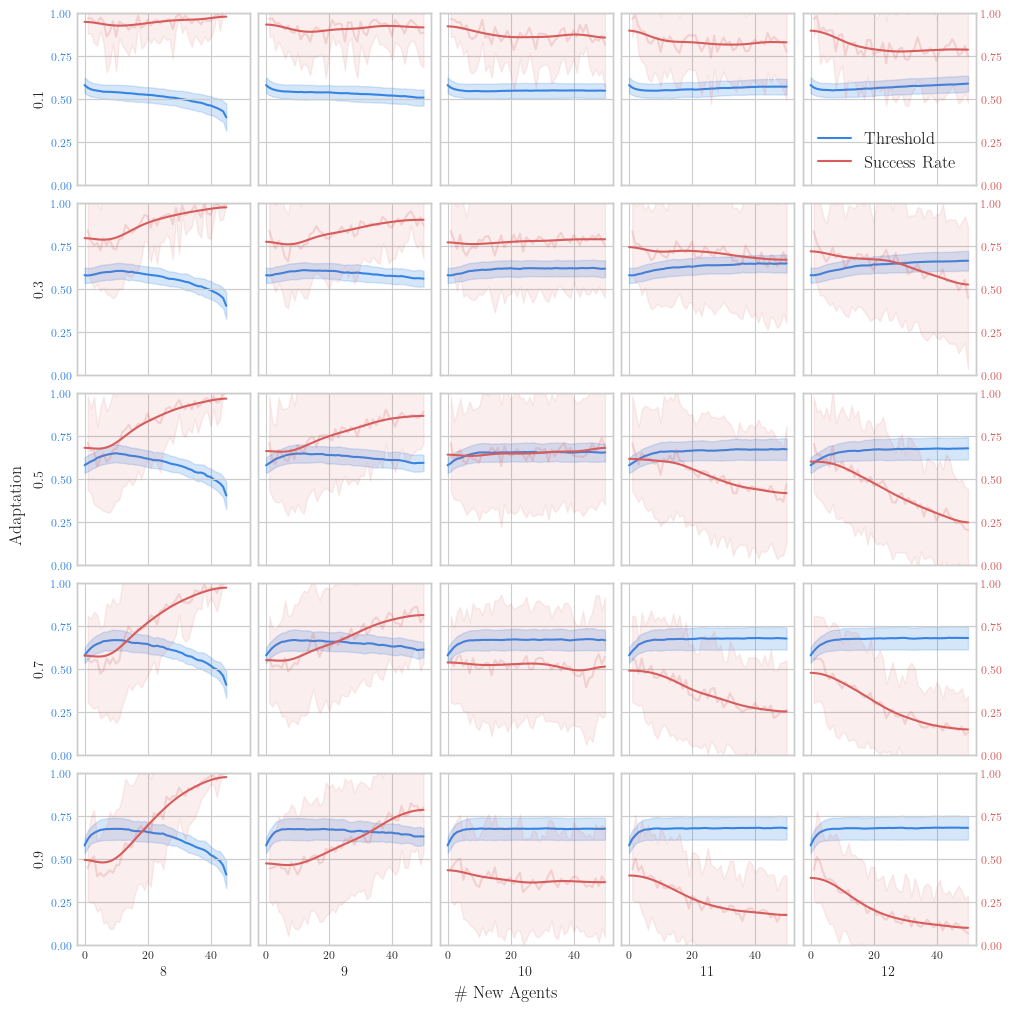

In [13]:
n_runs_simulations_scores_panel(all_runs_bla3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)
plt.savefig(
    join(SAVE_PATH, f"multiple_runs_{N_RUNS}_gaussian_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Bank Loan application - Binary adaptation

In [7]:
# Meta-simulation variables
N_LOANS_BLA2 = [10]  # number of loans is fixed
ADAPTATION_BLA2 = [8, 9, 10, 11, 12]
NEW_AGENTS_BLA2 = [8, 9, 10, 11, 12]
N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2

([10], [8, 9, 10, 11, 12], [8, 9, 10, 11, 12])

In [8]:
all_runs_bla2 = []
for i, random_state in enumerate(check_random_states(RNG_SEED, N_RUNS)):
    df, y, categorical = generate_synthetic_data(
        N_AGENTS, N_CONTINUOUS, N_CAT, random_state
    )

    lr = LogisticRegression(random_state=random_state).fit(df, y)
    population = BasePopulation(df, categorical=categorical)
    recourse = NFeatureRecourse(lr, n_features=2)

    def _meta_simulation(params):
        loans, adapt, agents = params
        environment = BankLoanApplication2(
            deepcopy(population),
            deepcopy(recourse),
            n_loans=loans,
            adaptation=adapt,
            new_agents=agents,
            random_state=random_state,
        )
        try:
            environment.run_simulation(50)
        except (ValueError, KeyError):
            pass

        return {
            "n_loans": loans,
            "adaptation": adapt,
            "new_agents": agents,
        }, environment

    results_bla2 = parallel_loop(
        _meta_simulation,
        list(product(N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)),
        n_jobs=-1,
        progress_bar=True,
        description=f"Run #{i}",
    )
    all_runs_bla2.append(results_bla2)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

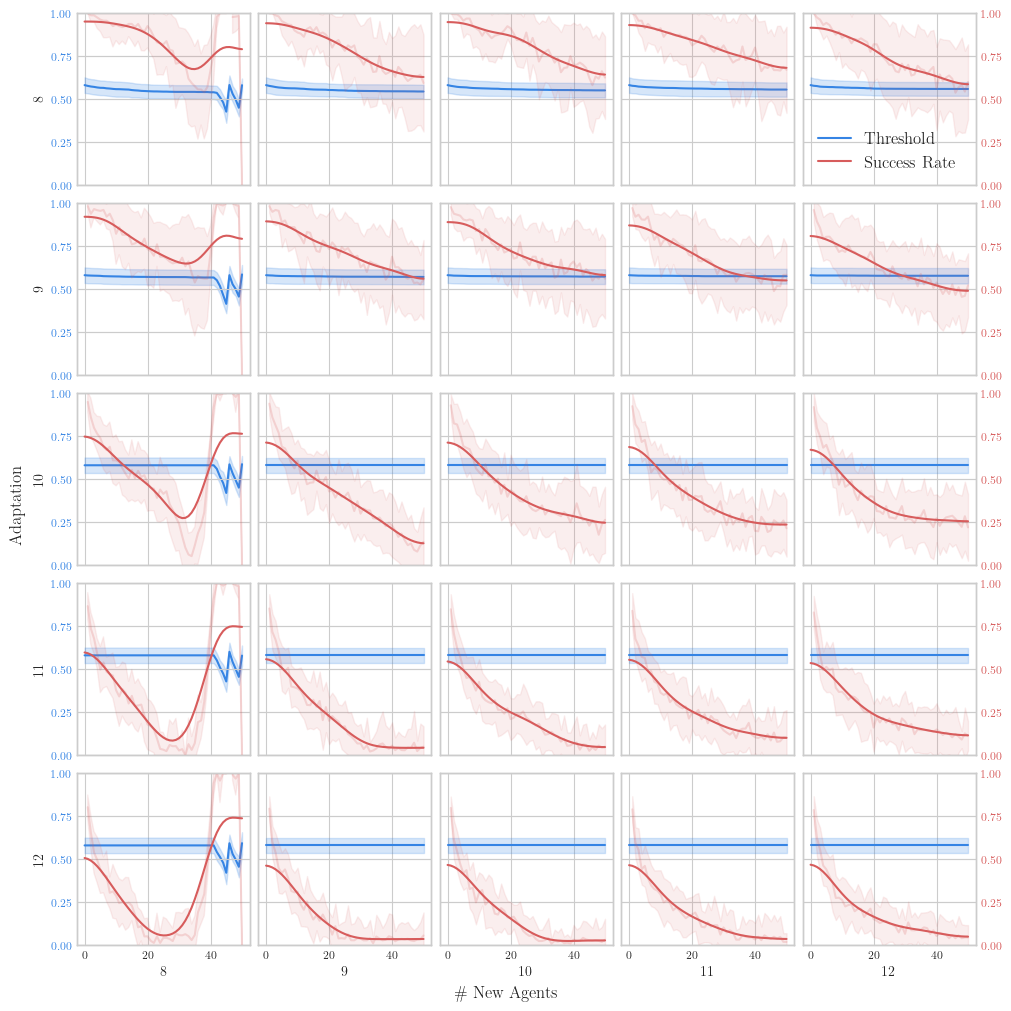

In [14]:
n_runs_simulations_scores_panel(all_runs_bla2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)
plt.savefig(
    join(SAVE_PATH, f"multiple_runs_{N_RUNS}_binary_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Willingness Environment

In [10]:
# Meta-simulation variables
N_LOANS_WILL = [10]  # number of loans is fixed
ADAPTATION_WILL = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_WILL = [8, 9, 10, 11, 12]
N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [11]:
all_runs_will = []
for i, random_state in enumerate(check_random_states(RNG_SEED, N_RUNS)):
    df, y, categorical = generate_synthetic_data(
        N_AGENTS, N_CONTINUOUS, N_CAT, random_state
    )

    lr = LogisticRegression(random_state=random_state).fit(df, y)
    population = BasePopulation(df, categorical=categorical)
    recourse = NFeatureRecourse(lr, n_features=2)

    def _meta_simulation(params):
        loans, adapt, agents = params
        environment = WillingnessEnvironment(
            deepcopy(population),
            deepcopy(recourse),
            n_loans=loans,
            adaptation=adapt,
            new_agents=agents,
            random_state=random_state,
        )
        try:
            environment.run_simulation(50)
        except ValueError:
            pass

        return {
            "n_loans": loans,
            "adaptation": adapt,
            "new_agents": agents,
        }, environment

    results_will = parallel_loop(
        _meta_simulation,
        list(product(N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL)),
        n_jobs=-1,
        progress_bar=True,
        description=f"Run #{i}",
    )
    all_runs_will.append(results_will)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

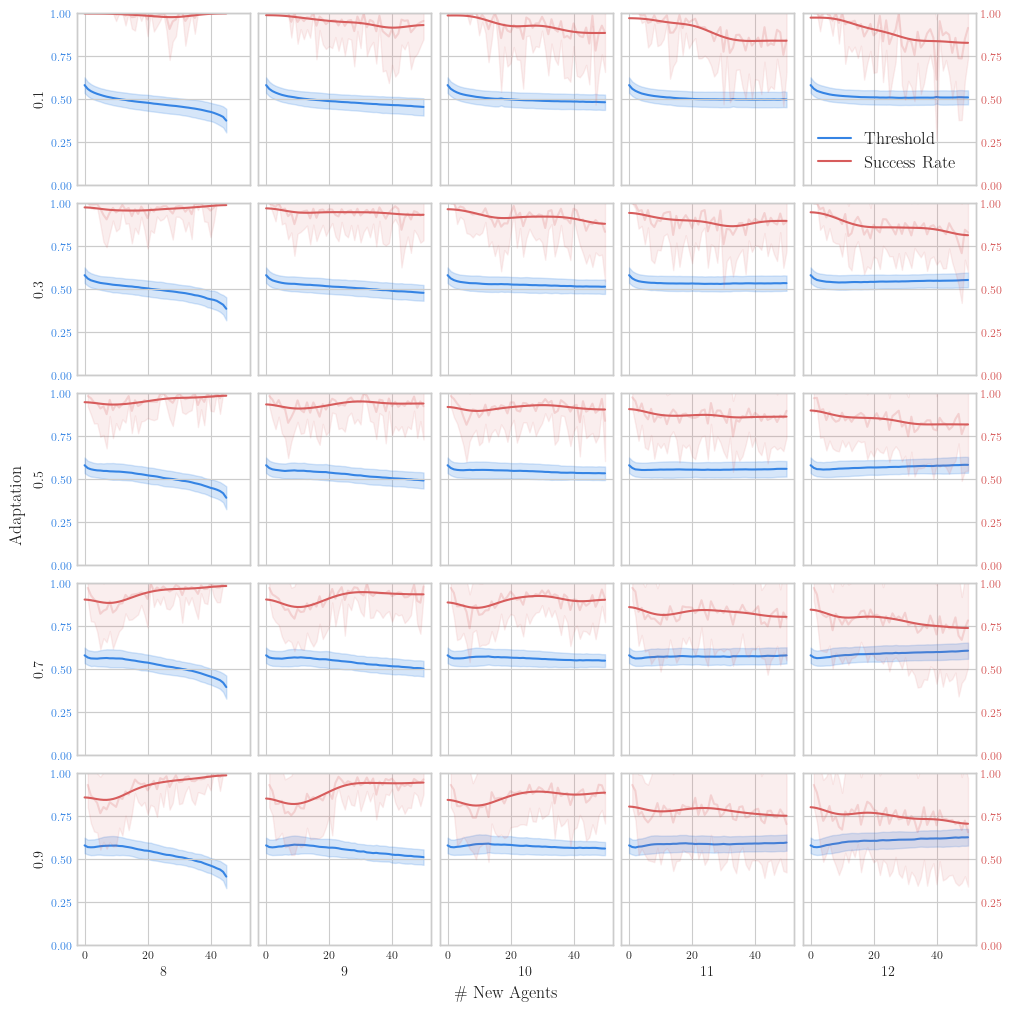

In [15]:
n_runs_simulations_scores_panel(all_runs_will, ADAPTATION_WILL, NEW_AGENTS_WILL)
plt.savefig(
    join(SAVE_PATH, f"multiple_runs_{N_RUNS}_willingness_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()